# Binary Logistic Regression Model

Based on the target values and using the test_trial method, we have set a threshold of 10.0 to convert the continuous target into a binary target. Subsequently, we employ the Logistic Regression algorithm on the input dataset with the binary target. We evaluate the model performance using the Confusion Matrix and Classification Report.

In [1]:
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import imblearn
import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import cm
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from utils import get_training_dataset

c:\Users\pauni\Desktop\Work\OCHA\GitHub\VirtualEnv\globaltyphoon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read csv file and import to df
df = get_training_dataset()
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,strong_roof_strong_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,NaN,22.580645,...,2.699781,5.762712,3445.709753,1,0.0,0.00,1.00,0.000000,0.0,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,2.639401,...,4.585088,12.799127,8602.645832,1,0.0,0.00,1.00,0.000000,0.0,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,2.639401,...,1.527495,8.833333,5084.012925,1,0.0,0.01,0.99,197.339034,0.0,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.639401,...,11.677657,17.530431,55607.865950,1,0.0,0.31,0.69,4970.477311,0.0,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,2.639401,...,17.074011,31.931338,35529.342507,1,0.0,0.77,0.23,12408.594656,0.0,0.0


In [4]:
# Fill NaNs with average estimated value of 'rwi'
df["rwi"].fillna(df["rwi"].mean(), inplace=True)

# Set any values >100% to 100%,
for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] > 100:
        df.at[i, "percent_houses_damaged"] = float(100)

In [5]:
# Define a threshold to separate target into damaged and not_damaged
thres = 10.0

for i in range(len(df)):
    if df.loc[i, "percent_houses_damaged"] >= thres:
        df.at[i, "binary_damage"] = 1
    else:
        df.at[i, "binary_damage"] = 0

df["binary_damage"] = df["binary_damage"].astype("int")

# Remove previous target 'percent_buildings_damaged' from the dataframe
df = df.drop(["percent_houses_damaged"], axis=1)

# Remove one of the rainfall features
df = df.drop(["rainfall_max_24h"], axis=1)
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,total_houses,rwi,strong_roof_strong_wall,strong_roof_light_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage
0,DURIAN,2006,101,0.0,303.180555,0.122917,31.000000,-0.213039,22.580645,77.419355,...,2.699781,5.762712,3445.709753,1,0.00,0.000000,1.000000,0.000000,0.000000,0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,3.301020,-0.527000,2.639401,42.182856,...,4.585088,12.799127,8602.645832,1,0.00,0.000000,1.000000,0.000000,0.000000,0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,12.103741,-0.283000,2.639401,42.182856,...,1.527495,8.833333,5084.012925,1,0.00,0.010000,0.990000,197.339034,0.000000,0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,645.899660,-0.358889,2.639401,42.182856,...,11.677657,17.530431,55607.865950,1,0.00,0.310000,0.690000,4970.477311,0.000000,0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,1071.731293,-0.462800,2.639401,42.182856,...,17.074011,31.931338,35529.342507,1,0.00,0.770000,0.230000,12408.594656,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141253,MOLAVE,2020,20677,0.0,644.575831,2.543750,4449.357133,0.508167,44.762048,46.504261,...,18.012771,36.304688,21559.003490,1,0.08,0.080000,0.840000,17619.701390,0.000000,0
141254,MOLAVE,2020,20678,0.0,655.685233,2.558333,1521.435795,-0.174100,44.762048,46.504261,...,13.163042,65.687266,12591.742022,1,0.00,0.420000,0.580000,5623.069564,0.000000,0
141255,MOLAVE,2020,20679,0.0,666.794635,2.975000,930.647069,-0.244286,25.078318,35.747923,...,10.901755,37.414996,19740.596834,1,0.00,0.109091,0.890909,5912.671746,0.015207,0
141256,MOLAVE,2020,20680,0.0,677.904037,2.889583,1800.666044,0.038000,16.796996,30.595298,...,17.917650,105.812452,26363.303778,1,0.03,0.250000,0.720000,11254.164413,0.020806,0


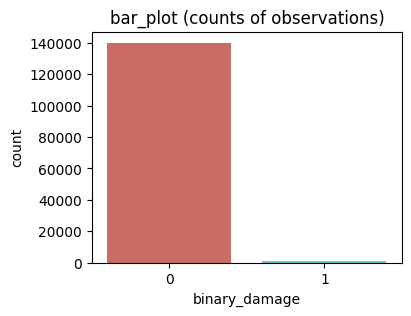

In [6]:
# Show bar plot
plt.figure(figsize=(4, 3))
sns.countplot(x="binary_damage", data=df, palette="hls")
plt.title("bar_plot (counts of observations)")
plt.show()

In [7]:
# Remove zeros from wind_speed
df = (df[(df[["wind_speed"]] != 0).any(axis=1)]).reset_index(drop=True)
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,total_houses,rwi,strong_roof_strong_wall,strong_roof_light_wall,strong_roof_salvage_wall,light_roof_strong_wall,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged_5years,binary_damage
0,DURIAN,12.460039,275.018491,0.670833,0.479848,-0.213039,31.336503,29.117802,0.042261,0.507132,...,34.629550,42.218750,5303.659490,1,0.00,0.00,1.00,0.000000,0.0,0
1,DURIAN,11.428974,297.027578,0.929167,55.649739,0.206000,23.447758,23.591571,0.037516,1.137998,...,25.475388,72.283154,61015.543599,1,0.00,0.14,0.86,276.871504,0.0,0
2,DURIAN,13.077471,262.598363,0.716667,8.157414,-0.636000,31.336503,29.117802,0.042261,0.507132,...,54.353996,102.215198,66707.438070,1,0.00,0.11,0.89,448.539453,0.0,0
3,DURIAN,12.511864,273.639330,0.568750,88.292015,-0.227500,31.336503,29.117802,0.042261,0.507132,...,31.814048,58.988877,53841.050168,1,0.00,0.12,0.88,2101.708435,0.0,0
4,DURIAN,11.977511,284.680297,0.589583,962.766739,-0.299667,23.546053,23.660429,0.037576,1.130137,...,25.976413,111.386527,87378.257957,1,0.07,0.46,0.47,11632.726327,0.0,0


array([[<AxesSubplot: title={'center': 'binary_damage'}>]], dtype=object)

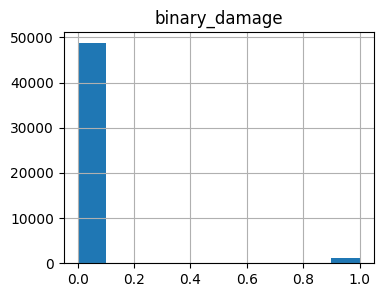

In [8]:
# Show histogram of damage
df.hist(column="binary_damage", figsize=(4, 3))

In [9]:
# Define bins and data stratification
bins2 = [0, 0.1, 1]
samples_per_bin2, binsP2 = np.histogram(df["binary_damage"], bins=bins2)

In [10]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["binary_damage"].value_counts(bins=binsP2)

(-0.001, 0.1]    48685
(0.1, 1.0]        1069
Name: binary_damage, dtype: int64

In [11]:
print(samples_per_bin2)
print(binsP2)

[48685  1069]
[0.  0.1 1. ]


In [12]:
bin_index2 = np.digitize(df["binary_damage"], bins=binsP2)

In [13]:
y_input_strat = bin_index2

In [14]:
# For this model we need to remove highly correlated features obtained from correlation_matrix code
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    # "rainfall_max_24h",
    "rwi",
    "mean_slope",
    # "std_slope",
    # "mean_tri",
    # "std_tri",
    # "mean_elev",
    "coast_length",
    # "with_coast",
    "urban",
    "rural",
    # "water",
    # "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["binary_damage"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rwi', 'mean_slope', 'coast_length', 'urban', 'rural',
       'percent_houses_damaged_5years'],
      dtype='object')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["binary_damage"], stratify=y_input_strat, test_size=0.2
)

In [16]:
# Check train data before resampling
print(Counter(y_train))

Counter({0: 38948, 1: 855})


In [17]:
# Ask the user whether to perform oversampling or undersampling
sampling_type = int(
    input(
        "Enter 1 for oversampling, 2 for undersampling or 3 for combination of both: "
    )
)

In [18]:
if sampling_type == 1:
    # Define oversampling strategy
    over = RandomOverSampler(sampling_strategy=0.1)
    # Fit and apply the transform
    X_train, y_train = over.fit_resample(X_train, y_train)

elif sampling_type == 2:
    under = RandomUnderSampler(sampling_strategy=0.7)
    X_train, y_train = under.fit_resample(X_train, y_train)

elif sampling_type == 3:
    over = RandomOverSampler(sampling_strategy=0.1)
    X_train, y_train = over.fit_resample(X_train, y_train)

    under = RandomUnderSampler(sampling_strategy=0.7)
    X_train, y_train = under.fit_resample(X_train, y_train)


else:
    print("Invalid input. Please enter 1, 2 or 3.")

In [19]:
# Check train data After resampling
print(Counter(y_train))

Counter({0: 38948, 1: 3894})


In [20]:
# Define binary logistic regression model

model = LogisticRegression(solver="liblinear", random_state=0)
model.fit(X_train, y_train)

LogisticRegression(
    C=1.0,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    # max_iter=100,
    multi_class="warn",
    n_jobs=None,
    penalty="l2",
    random_state=0,
    solver="liblinear",
    tol=0.0001,
    verbose=0,
)

LogisticRegression(multi_class='warn', random_state=0, solver='liblinear')

In [21]:
y_pred = model.predict(X_test)

In [22]:
# Check the coefficient values of features
model.coef_

array([[ 1.94433232, -0.60166961, -0.53764254,  0.36289608, -0.17916852,
        -0.28312406,  0.2224347 , -0.21143283, -0.0620838 ,  0.23632697]])

In [23]:
model.score(X_train, y_train)

0.9558377293310303

In [24]:
# Confusion Matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[9560,  177],
       [  63,  151]], dtype=int64)

In [25]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      9737
           1       0.46      0.71      0.56       214

    accuracy                           0.98      9951
   macro avg       0.73      0.84      0.77      9951
weighted avg       0.98      0.98      0.98      9951



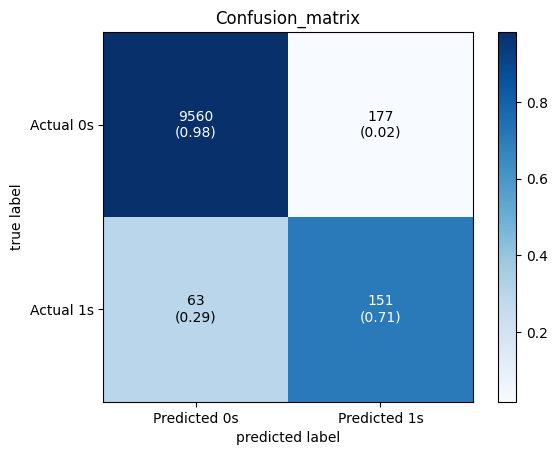

In [26]:
# Plot Confusion Matrix (Binary absolute and relative with colorbar)
fig, ax = plot_confusion_matrix(
    confusion_matrix(y_test, y_pred),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)

ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
plt.title("Confusion_matrix")
plt.show()

## Feature Importance 

In [27]:
# insert coefficient values in a list
coef_lst = model.coef_[0].tolist()

# insert coefficient values in a df
df_coef = pd.DataFrame(columns=["feature", "coef_value"])
for i in range(len(features)):
    df_coef.at[i, "feature"] = features[i]
    df_coef.at[i, "coef_value"] = coef_lst[i]

df_coef

,feature,coef_value
0,wind_speed,1.944332
1,track_distance,-0.60167
2,total_houses,-0.537643
3,rainfall_max_6h,0.362896
4,rwi,-0.179169
5,mean_slope,-0.283124
6,coast_length,0.222435
7,urban,-0.211433
8,rural,-0.062084
9,percent_houses_damaged_5years,0.236327


In [28]:
# Sorting the dataframe of coefficient values in a descending order

final_sorted_df = df_coef.sort_values(by=["coef_value"], ascending=False)
final_sorted_df = final_sorted_df.reset_index(drop=True)
final_sorted_df

,feature,coef_value
0,wind_speed,1.944332
1,rainfall_max_6h,0.362896
2,percent_houses_damaged_5years,0.236327
3,coast_length,0.222435
4,rural,-0.062084
5,rwi,-0.179169
6,urban,-0.211433
7,mean_slope,-0.283124
8,total_houses,-0.537643
9,track_distance,-0.60167


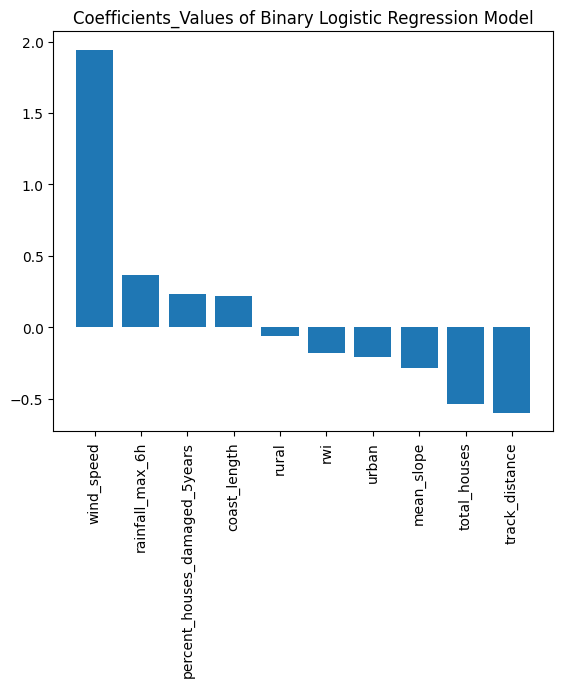

In [29]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_axes([0, 0, 1, 1])
# ax.bar(features,values)
ax.bar(final_sorted_df["feature"], final_sorted_df["coef_value"])
np.rot90(plt.xticks(rotation=90, fontsize=10))
ax.set_title(
    "Coefficients_Values of Binary Logistic Regression Model", fontsize=12
)
plt.show()